In [1]:
import os
import time

import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
# from scipy.io import savemat
# from scipy.io import loadmat as loadmat2
# from mat73 import loadmat
import h5py
# import hdf5storage

### Functions

In [2]:
# Reduce data size
def calc_Date(image,llist):
    value = image.get('system:time_start')
    value = ee.Number(ee.Date(ee.List([value, -9999]).\
                            reduce(ee.Reducer.firstNonNull())).millis());
    return ee.List(llist).add(value)

In [7]:
def selection(image):
    date = image.get('system:time_start')
    im = image.select(maskband).reproject(crs_mod,trans_mod).bitwiseAnd((46851))
    image = image.select(band).updateMask(im.gt(0).And(im.neq(3)).Not())
    image = image.updateMask(image.gt(0))

    value = image.select(band[0]).mask().reduceRegion(**{'reducer':ee.Reducer.mean(),
                                                         'geometry':region,
                                                         'crs':crs_mod,
                                                         'crsTransform':trans_mod,
                                                         'bestEffort':True})
    value = ee.Number(value.get(value.keys().get(0)))
    return image.set('Valid_perc',value).set('system:time_start',date)


In [5]:
def selimage(nday):
    image=ee.ImageCollection(product1).filterDate(ee.Date(nday),
                                                  ee.Date(ee.Number(nday).add(86400000))).filterBounds(region).select(band).first()
    #.reduce(ee.Reducer.mean()).rename(band[0]).reproject(crs_mod,trans_mod)

    image2=ee.ImageCollection(product2).filterDate(ee.Date(nday),
                                                   ee.Date(ee.Number(nday).add(86400000))).filterBounds(region).select(maskband).first()
    #.reduce(ee.Reducer.mean()).rename(maskband).reproject(crs_mod,trans_mod)

    image2=image2.bitwiseAnd((46851)).reproject(crs_mod,trans_mod)

    return image.updateMask(image2.gt(0).And(image2.neq(3)).Not())

### Setup

In [8]:
ee.Authenticate()

True

In [9]:
folderGEE = 'projects/MODIS-discharge'
user ='fbennitt'
service_account = 'modis-discharge@modis-discharge.iam.gserviceaccount.com'
key = '/home/fbennitt_umass_edu/modis-discharge-411743fe59a9.json'

In [10]:
credentials = ee.ServiceAccountCredentials(service_account, key)

In [11]:
ee.Initialize(credentials)

In [12]:
save_path = '/nas/cee-water/cjgleason/data/MODIS/'

In [13]:
products = ['MOD','MYD']
ray = 0.075

In [14]:
file = pd.read_parquet('/nas/cee-water/cjgleason/fiona/MODIS_discharge/data/gauges_sampled.parquet')
file.columns

Index(['Sttn_Nm', 'start', 'end', 'obs', 'missed', 'continent', 'lon', 'lat'], dtype='object')

In [24]:
file

,Sttn_Nm,start,end,obs,missed,continent,lon,lat
0,1749100_GRDC,1911.0,2016.0,32202,6451,Africa,18.583333,4.366667
1,1291100_GRDC,1942.0,2018.0,23954,3655,Africa,24.300000,-17.467000
2,1472_In_IWRIS,1977.0,2020.0,15236,623,Asia,76.993611,22.490278
3,1853_In_IWRIS,1965.0,2019.0,19226,230,Asia,81.659722,17.245833
4,6935051_GRDC,1869.0,2018.0,54786,0,Europe,7.616700,47.559400
5,6242501_GRDC,1996.0,2017.0,8036,0,Europe,16.343750,48.360416
6,07076750_USGS,1927.0,2021.0,11278,23048,North America,-91.449722,35.128889
7,07263450_USGS,2016.0,2020.0,1463,0,North America,-92.358333,34.793056
8,130379A_BOM,2017.0,2021.0,1380,7,Oceania,150.815630,-24.452572
9,5868100_GRDC,1954.0,2020.0,24265,19,Oceania,169.747983,-46.237280


In [15]:
name = file['Sttn_Nm'].to_list()
lon = file['lon'].to_list()
lat = file['lat'].to_list()
lonlat = list(zip(lon, lat))

In [ ]:
for i in range(0,1):
    
    coords = lonlat[i] #Central area coordinates. NB coordstat should not be taken inside river since snow period selection is calculated there
    years = [2000, 2021] #Calibration period (has to be < 5000 days)
        
    #region = ee.Geometry.Point(coordstat).buffer(ray*100000).bounds()
    region = ee.Geometry.Rectangle([coords[0] - ray, coords[1] - ray,
                                  coords[0] + ray, coords[1] + ray])
    
    for prod in products:
        product1 = 'MODIS/061/' + prod + '09GQ';
        product2 = 'MODIS/061/' + prod + '09GA';

        datestartCAL = ee.Date(str(years[0]) + '-01-01').millis();
        dateendCAL = ee.Date(str(years[-1]) + '-12-31').millis();
        
        band = ['sur_refl_b01', 'sur_refl_b02'];
        
        coll = ee.ImageCollection(product1).filterDate(datestartCAL, dateendCAL).filterBounds(region).select(band);
        proj = coll.first().projection();
        scale_mod = ee.Number(proj.nominalScale()).getInfo()
        trans_mod = proj.getInfo()['transform'];
        crs_mod = proj.getInfo()['crs'];

        maskband = 'state_1km';

        coll2 = ee.ImageCollection(product2).filterDate(datestartCAL, dateendCAL).filterBounds(region).select(maskband);
        coll = coll.combine(coll2)
        n = coll.size().getInfo()
        print('dimension premasking: ' + str(n))
        
        coll0=coll.map(selection)
        coll0=coll0.filterMetadata('Valid_perc', 'not_less_than', 0.20)
        first=ee.List([])
        dlistn=ee.List(coll0.iterate(calc_Date,first)).distinct().getInfo()
        dlistn=np.sort(dlistn).tolist()
        
        coll=ee.ImageCollection(ee.List(dlistn).map(selimage))

        n=coll.size().getInfo()
        
        print('dimension postmasking: '+ str(n))
        
        MOD0 = np.array(ee.ImageCollection(coll.first()).select(band).getRegion(region, scale_mod).getInfo())
        
        MOD = np.zeros([np.shape(MOD0)[0]-1, 5, n])
        
        start = time.time()
        for i in range(n):
            print('reading image ' + str(i) + ' of ' + str(n))
            tic=time.time()
            ee.Initialize(credentials)

            nn=0
            while nn<3:
                try:
                    nn+=1
                    coll0=ee.ImageCollection(ee.Image(ee.List(coll.toList(n)).get(i)))
                    arr=np.array(coll0.getRegion(region, scale_mod).getInfo())
                    arr=arr[1:,1:].astype(float)                
                    MOD[:,:,i]=arr
                finally:
                    nn=4
            toc=time.time()
            print(toc-tic)
        end = time.time()
        print('That took ' + (end-start))
        
        D=MOD[0,2,:]
        llonlat=MOD[:,0:2,0]
        surf2=MOD[:,3,:]
        surf1=MOD[:,4,:]
        #cloud=MOD[:,5,:]
        matfiledata = {}
        matfiledata['surf2'] = surf2
        matfiledata['surf1'] = surf1
        #matfiledata['cloud'] = cloud
        matfiledata['D'] = D

In [42]:
D=MOD[0,2,:]
llonlat=MOD[:,0:2,0]
surf2=MOD[:,3,:]
surf1=MOD[:,4,:]
#cloud=MOD[:,5,:]
matfiledata = {}
matfiledata['surf2'] = surf2
matfiledata['surf1'] = surf1
#matfiledata['cloud'] = cloud
matfiledata['D'] = D
matfiledata['lonlat'] = llonlat

In [43]:
matfiledata['lonlat']

array([[18.50949428,  4.29207173],
       [18.51157529,  4.29207173],
       [18.51365629,  4.29207173],
       ...,
       [18.65308359,  4.43982304],
       [18.6551646 ,  4.43982304],
       [18.6572456 ,  4.43982304]], shape=(5184, 2))

In [18]:
# Convert the array to a pandas DataFrame
df = pd.DataFrame(MOD0[1:, :], columns=MOD0[0, :])

# Convert the 'time' column to datetime objects
df['time'] = pd.to_datetime(df['time'], unit='ms')

df['sur_refl_b01'] = df['sur_refl_b01'].astype(float)

df = df.set_index(['longitude', 'latitude', 'time'])

In [21]:
ds = df.to_xarray()

In [22]:
ds

<xarray.Dataset> Size: 126kB
Dimensions:       (longitude: 72, latitude: 72, time: 1)
Coordinates:
  * longitude     (longitude) float64 576B 18.51 18.51 18.51 ... 18.66 18.66
  * latitude      (latitude) float64 576B 4.292 4.294 4.296 ... 4.436 4.438 4.44
  * time          (time) datetime64[ns] 8B 2002-07-09
Data variables:
    id            (longitude, latitude, time) object 41kB '2002_07_09' ... '2...
    sur_refl_b01  (longitude, latitude, time) float64 41kB 465.0 465.0 ... nan
    sur_refl_b02  (longitude, latitude, time) object 41kB 3628 3628 ... None

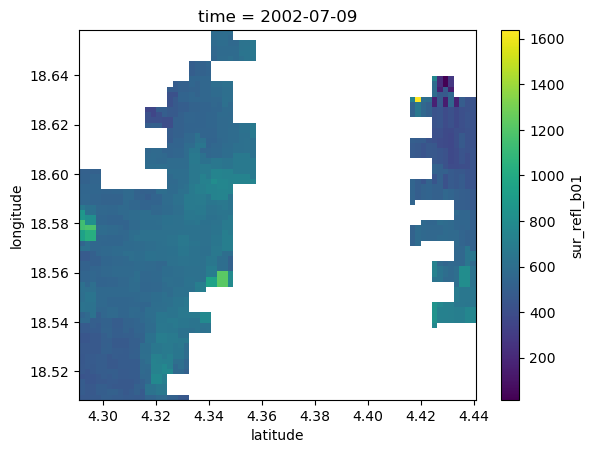

In [23]:
ds['sur_refl_b01'].plot()